## Load the required packages

In [1]:
require(ROCR);
require(caret)
require(randomForest)
require(e1071)
require(pROC)

Loading required package: ROCR
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2
Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: e1071
Loading required package: pROC
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



### Load dataset and change quality to binary
Binary classification (Good/bad wine) was used to make balanced target class data

In [2]:
df <- read.csv("winequality-red.csv", header=TRUE, sep = ";")
df <- df[,2:13]
df$quality[df$quality == 9] <- 1
df$quality[df$quality == 8] <- 1
df$quality[df$quality == 7] <- 1
df$quality[df$quality == 6] <- 1
df$quality[df$quality == 5] <- 0
df$quality[df$quality == 4] <- 0
df$quality[df$quality == 3] <- 0
df$quality <- as.factor(df$quality)

# Random Forest Classifier

## Grid search through Random Forest parameters to record ones that give highest AUC Score
* ntree = [1000] - number of trees to consider
* mtry = [sq.root(n_feat)/2, sq.root(n_feat), sq.root(n_feat)*2] - number of features considered choosing best plit
* cutoff = ([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], [1-cutoff]) - percentage of trees that need to vote for True to classify True

In [3]:
auc_best = 0.0
n_feat = length(df) - 1
best = c(0,0,0)
ntree = 1000
    for (mtry in c(as.integer(sqrt(n_feat)/2 + 1), as.integer(sqrt(n_feat)), as.integer(sqrt(n_feat)*2))){
        for (cutoff in c(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)){
            rfc <- randomForest(quality~., data=df, cutoff = c(cutoff, 1-cutoff), ntree=ntree, mtry=mtry)
            rfc.roc <- roc(df$quality, rfc$votes[,2])
            auc_score <- auc(rfc.roc)
            if (auc_score > auc_best){
                auc_best = auc_score
                best = c(ntree,mtry,cutoff)
            }
            }
        }



In [4]:
out <- sprintf("Best AUC_Score settings: \n \n Ntree: %4d \n Mtry: %2d \n Cutoff: %1.2f \n AUCScore: %1.4f",best[1], best[2], best[3], auc_best)
cat(out)

Best AUC_Score settings: 
 
 Ntree: 1000 
 Mtry:  2 
 Cutoff: 0.90 
 AUCScore: 0.9108

### Train classifier with best parameters

In [5]:
rfc <- randomForest(quality~., data=df, cutoff = c(best[3], 1-best[3]), ntree=best[1], mtry=best[2], importance = TRUE)

# Support Vector Classifier

In [6]:
set.seed(1000)

## Normalize the data with 0 mean and unit variance

In [7]:
df_norm <- df
df_norm[colnames(df) != 'quality'] <- scale(df_norm[colnames(df_norm) != 'quality'], center = TRUE, scale = FALSE)

## Split the data int *train* and *test* sections to determine AUC Score

In [8]:
n <- nrow(df_norm)
shuffled_df <- df_norm[sample(n), ]
train_indices <- 1:round(0.75 * n)
train_norm <- shuffled_df[train_indices, ]
test_indices <- (round(0.75 * n) + 1):n
test_norm <- shuffled_df[test_indices, ]

### Create functions for measuring accuracy

In [9]:
F1_Score <- function (data, labels){
    
    pred <- predict(svc,data)
    recall <- table(pred, labels)[4]/(table(pred, labels)[3]+table(pred, labels)[4])
    precision <- table(pred, labels)[4]/(table(pred, labels)[4]+table(pred, labels)[2])
    f1_score <- 2*precision*recall/(precision + recall)
    f1_score
    }

AUC_Score <- function(classifier, data,labels){
    pred <- predict(classifier,data, probability = TRUE)
    pred.prob <- attr(pred, "prob")[,1]
    svc.roc <- roc(labels, pred.prob)
    auc(svc.roc)
}

## Grid Search through SVM parameter values to determine ones with best AUC Score
C = [0.001, 0.002154435, 0.004641589, 0.01, 0.021544,0.03125,  0.06250,  0.12500,  0.25000,  0.50000,  1.00000,  2.00000,  4.00000,
8.00000, 16.00000, 32.00000] - Cost of misclassification


In [10]:
bestSvc = c(0)
auc_best_svc = 0.0
for(C in c(0.001, 0.002154435, 0.004641589, 0.01, 0.021544,0.03125,  0.06250,  0.12500,  0.25000,  0.50000,  1.00000,  2.00000,  4.00000,
8.00000, 16.00000, 32.00000)) {
    
    svc <- svm(quality~.,data=train_norm,kernel='linear',cost=C, probability= TRUE)
    auc_score <- AUC_Score(svc, test_norm, test_norm$quality)
    if (auc_score > auc_best_svc){
        auc_best_svc = auc_score
        bestSvc = c(C)
    }
}

In [11]:
svc <- svm(quality~.,data=train_norm,kernel='linear',cost=bestSvc[1])
out <- sprintf("Best AUC_Score settings:\n\nC: %2.4f\nAUCScore: %1.4f", bestSvc[1] ,auc_best_svc)
cat(out)

Best AUC_Score settings:

C: 0.0100
AUCScore: 0.8163

# Feature Ranking

### RandomForest: MDA+ and MDA-

In [12]:
var.importance <- importance(rfc, type = 1, class=0)
var.importance <- cbind(var.importance, importance(rfc, type = 1, class=1))
print("RandomForest variable importances using importance from randomForest package (MDA-) and (MDA+) ordered by MDA+")
var.importance[order(var.importance[,2], decreasing=TRUE), , drop=FALSE]

[1] "RandomForest variable importances using importance from randomForest package (MDA-) and (MDA+) ordered by MDA+"


,0,1
alcohol,71.41716,68.80679
sulphates,60.17351,65.53652
total.sulfur.dioxide,47.74823,51.44011
volatile.acidity,52.58180,42.78310
density,36.59995,42.58374
pH,34.66306,36.61210
citric.acid,32.06963,36.58707
fixed.acidity,32.44268,35.62360
chlorides,40.40680,34.75798
residual.sugar,31.79940,34.13174


### Support Vector Machine: |Wj|

In [13]:
w <- t(svc$coefs) %*% svc$SV
w <- abs(w)
w <- t(w)
print("SVM variable importance according to absolute values of respective weights ")
w <- w[order(w, decreasing=TRUE), , drop=FALSE]
w

[1] "SVM variable importance according to absolute values of respective weights "


alcohol,0.65434318
volatile.acidity,0.35143736
sulphates,0.31146159
total.sulfur.dioxide,0.26809921
fixed.acidity,0.17551552
chlorides,0.13836015
density,0.10858024
free.sulfur.dioxide,0.08524902
citric.acid,0.07218056
residual.sugar,0.04953407
pH,0.02388289


## Train new models with 1/2 of most important features

In [21]:
new_rfc <- randomForest(quality~., data=df[c(rownames(head(var.importance, as.integer(n_feat/2))), "quality")], cutoff = c(best[3], 1-best[3]), ntree=best[1], mtry=best[2], importance = TRUE)

In [22]:
new_svc <- svm(quality~.,data=train_norm[c(rownames(head(var.importance, as.integer(n_feat/2))), "quality")],kernel='linear',gamma=0.2,cost=bestSvc[1], probability = TRUE)

## Test new models' accuracy

In [23]:
new_rfc.roc <- roc(df$quality, new_rfc$votes[,2])
new_rfc.auc_score <- auc(new_rfc.roc)
new_svc.auc_score <- AUC_Score(new_svc, test_norm[c(rownames(head(var.importance, as.integer(n_feat/2))), "quality")], test_norm$quality)
out <- sprintf("New RF Classifier AUC Score: %1.4f\nNew SV Classifier AUC Score: %1.4f", new_rfc.auc_score, new_svc.auc_score)
cat(out)

New RF Classifier AUC Score: 0.8349
New SV Classifier AUC Score: 0.6796

## Visualize data

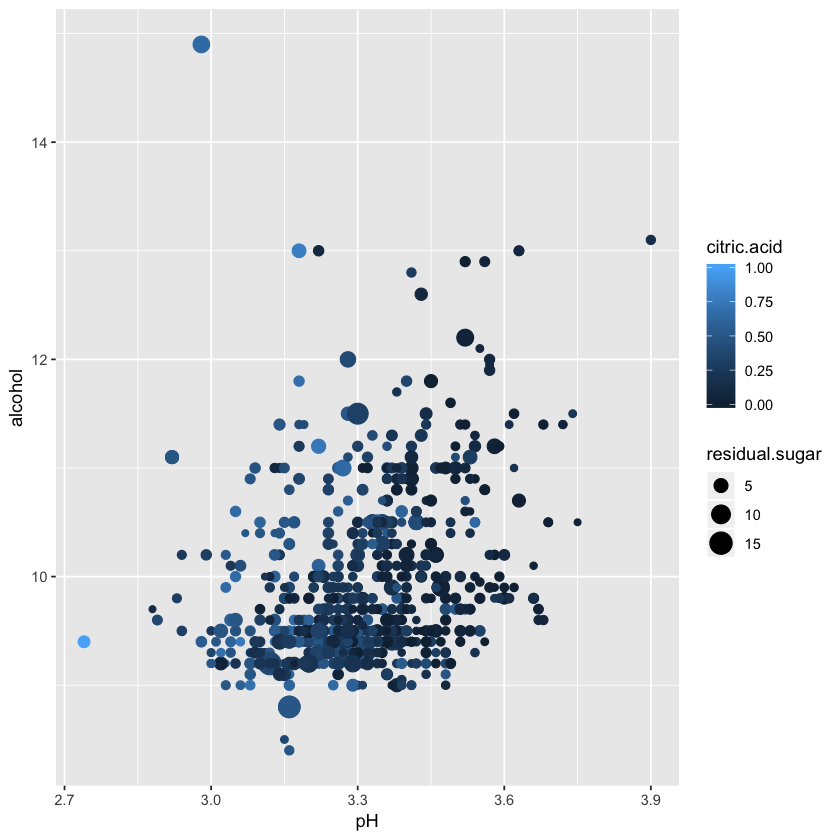

In [17]:
library(ggplot2)
ggplot(data=df[df$quality == 0,]) + 
  geom_point(mapping = aes(x = pH, y = alcohol, color = citric.acid, size = residual.sugar))

## Plotting of data with respect to some of the most important features
* Small green - False Positive
* Large green - True Positive
* Small red - True Negative
* Large red - False Negative


### RFC results

Warning message:
“Using size for a discrete variable is not advised.”

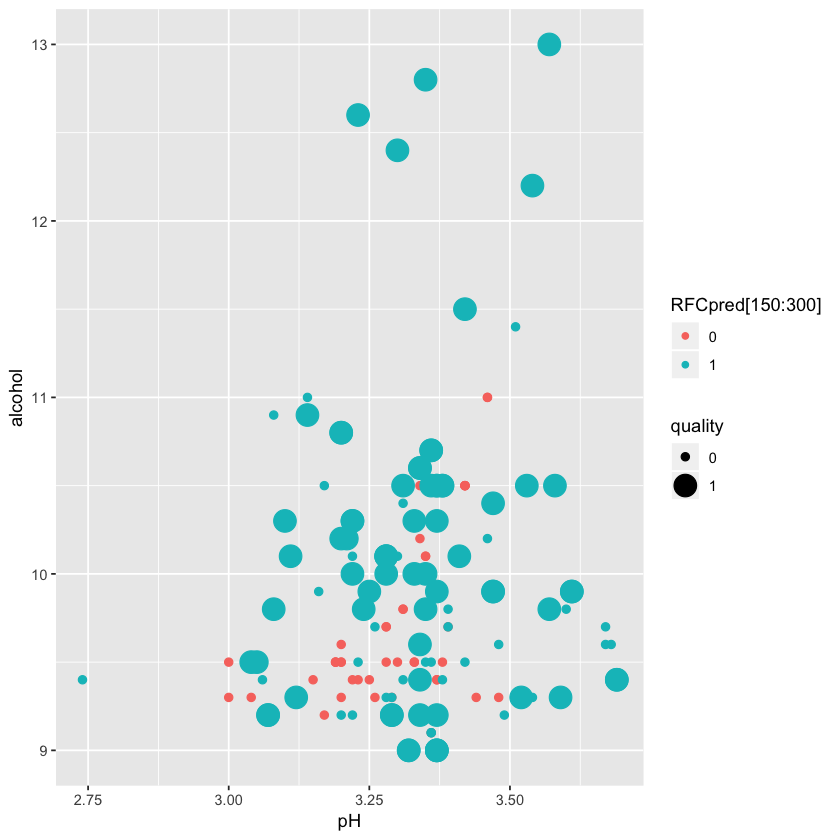

In [18]:
RFCpred <- predict(rfc, df)

ggplot(data=df[150:300,]) + 
  geom_point(mapping = aes(x = pH, y = alcohol, color = RFCpred[150:300], size = quality))

###  SVC results

Warning message:
“Using size for a discrete variable is not advised.”

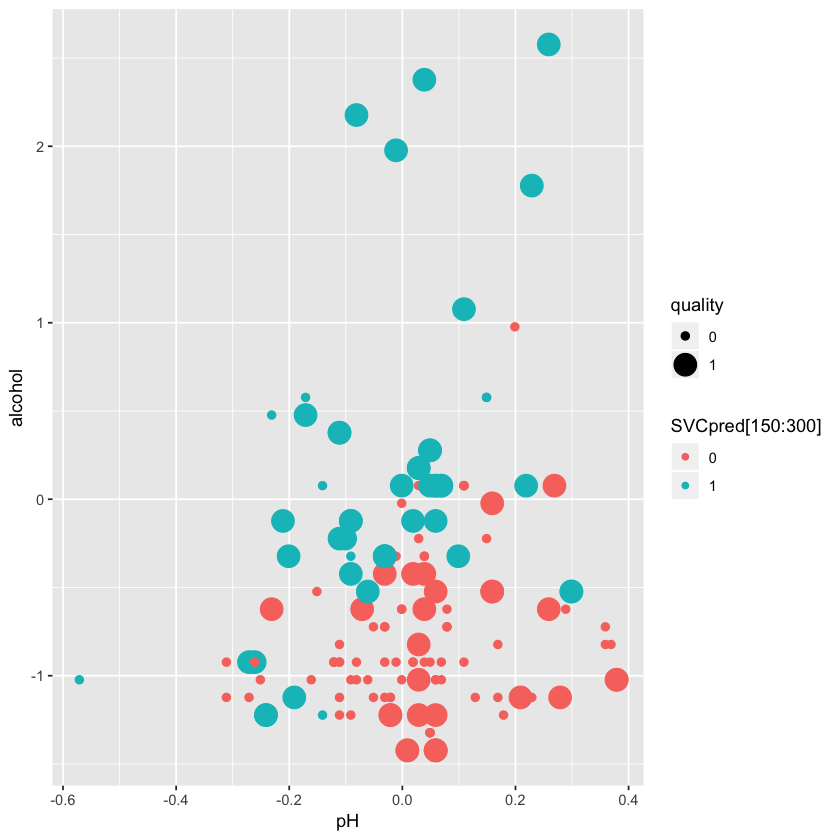

In [19]:
svc <- svm(quality~.,data=train_norm,kernel='linear',gamma=0.2,cost=bestSvc[1])
SVCpred <- predict(svc, df_norm[1:11])
ggplot(data=df_norm[150:300,]) + 
  geom_point(mapping = aes(x = pH, y = alcohol, color = SVCpred[150:300], size = quality))